In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from dataset import BratsSupervisedDataset, BratsUnsupervisedDataset
from glob import glob
import albumentations as A

In [2]:
img_paths = glob('/mnt/asgard2/data/lingkai/braTS20/slice/image/*')
mask_paths = glob('/mnt/asgard2/data/lingkai/braTS20/slice/mask/*')

train_transform = A.Compose(
        [
        # A.CropNonEmptyMaskIfExists(height=150, width=150),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(1.0, 1.5), p=0.15),
        A.Affine(translate_percent=(0, 0.25), p=0.5),
        A.GaussianBlur(sigma_limit=(0.5, 1.5), p=0.15), 
        A.GaussNoise(var_limit=(0, 0.33), p=0.15),
        A.RandomBrightness(limit=(0.7, 1.3), p=0.15),
        A.RandomContrast(limit=(0.65, 1.5), p=0.15)],
        additional_targets={'t1': 'image', 't1ce': 'image', 't2': 'image', 'tumorCore': 'mask', 'enhancingTumor': 'mask'}
    )
train_unsupervise_dataset = BratsUnsupervisedDataset(img_paths, augmentation=train_transform)
train_supervise_dataset = BratsSupervisedDataset(img_paths, mask_paths, augmentation=None)
train_unsupervise_loader = torch.utils.data.DataLoader(
        train_unsupervise_dataset,
        batch_size=7,
        shuffle=True,
        pin_memory=True,
        drop_last=True)

train_supervise_loader = torch.utils.data.DataLoader(
        train_supervise_dataset,
        batch_size=1,
        shuffle=True,
        pin_memory=True,
        drop_last=True)

for i, (data1, data2) in enumerate(zip(train_supervise_loader, train_unsupervise_dataset)):
    image1, target1 = data1
    image2, target2 = data2

/home/lingkai/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/lingkai/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


KeyboardInterrupt: 

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import nibabel as nib
import numpy as np
from random import randint
import monai.transforms as transforms
import albumentations as A
from random import gauss

class BratsTrainDataset(Dataset):
    def __init__(self, datapath='/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData', augmentation=None):
        self.augmentaion = augmentation
        self.datapath = datapath
        self.volumeType = ['flair', 't1ce', 't1', 't2', 'seg']
    def __getitem__(self, index):
        # 1st volume
        images = {}
        folderpaths = os.path.join(self.datapath, f'BraTS20_Training_{str(index+1).zfill(3)}')
        for name in self.volumeType:
            img = nib.load(os.path.join(folderpaths, f'BraTS20_Training_{str(index+1).zfill(3)}_{name}.nii')).get_fdata()
            if name == 'seg':
                img[img==4] = 3
            images[name] = img
        # # 2nd volume
        # images1 = {}
        # while True:
        #     index1 = randint(0, len(os.listdir(self.datapath)) - 1)
        #     if index1 != index: break
        
        # folderpaths1 = os.path.join(self.datapath, f'BraTS20_Training_{str(index1+1).zfill(3)}')
        # for name in self.volumeType:
        #     img = nib.load(os.path.join(folderpaths1, f'BraTS20_Training_{str(index1+1).zfill(3)}_{name}.nii')).get_fdata()
        #     if name == 'seg':
        #         img[img==4] = 3
        #     images1[name] = img
        # if self.augmentaion:
        #     images1 = self.augmentaion(image=images1['flair'],mask=images1['seg'])

        # normalize the non-zero voxels in images
        images['flair'] = self.normalize(images['flair'])
        images['t1ce'] = self.normalize(images['t1ce'])
        images['t1'] = self.normalize(images['t1'])
        images['t2'] = self.normalize(images['t2'])

        # images1['flair'] = self.normalize(images1['flair'])
        # images1['t1ce'] = self.normalize(images1['t1ce'])
        # images1['t1'] = self.normalize(images1['t1'])
        # images1['t2'] = self.normalize(images1['t2'])
        # images = self.crop(images)
        image_slice1, seg_slice1 = self.get_slice(images)
        image_slice2, seg_slice2 = self.get_slice(images)
        whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.mask_label_process(seg_slice1)
        whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2 = self.mask_label_process(seg_slice2)
        if self.augmentation is not None:
            image1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.data_transform(
                image_slice1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1
            )
            image2, whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2 = self.data_transform(
                image_slice2, whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2
            )
        label1 = np.concatenate((whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1), axis=0)
        label2 = np.concatenate((whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2), axis=0)
        return image1, image2, label1, label2

    def __len__(self):
        return len(os.listdir(self.datapath)) - 1
    
    def crop_center(self, img, cropx=160, cropy=160):
        y, x = img.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        return img[starty:starty+cropy, startx:startx+cropx]


    def normalize(self, input):
        normalizeIntensity = transforms.NormalizeIntensity(nonzero=True)
        input_norm = normalizeIntensity(input)
        return input_norm

    def get_slice(self, images):
        _, _, max_z = images['flair'].shape
        while True:
            slice_z_num = randint(0, max_z-1)
            if np.max(images['seg'][:, :, slice_z_num]) != 0: break

        # slice_z_num1 = int(gauss(slice_z_num, 0.25))
        # if slice_z_num1 < 0: slice_z_num = 0 
        # if slice_z_num1 > max_z - 1 : slice_z_num1 = max_z - 1
        # 1st slice of the pair
        flair = np.expand_dims(self.crop_center(images['flair'][:, :, slice_z_num]),axis=0)
        t1ce = np.expand_dims(self.crop_center(images['t1ce'][:, :, slice_z_num]), axis=0)
        t1 = np.expand_dims(self.crop_center(images['t1'][:, :, slice_z_num]), axis=0)
        t2 = np.expand_dims(self.crop_center(images['t2'][:, :, slice_z_num]), axis=0)
        seg = self.crop_center(images['seg'][:, :, slice_z_num])
        image = np.concatenate((flair, t1ce, t1, t2), axis=0)
        # 2nd 
        return image.astype('float32'), seg.astype('uint8')

    def data_transform(self, image, whole_tumor_label, tumor_core_label, enhanced_tumor_label):
        transformed = self.augmentation(image=image[0, :, :], t1=image[1, :, :], t1ce=image[2, :, :], t2=image[3, :, :], mask=whole_tumor_label, tumorCore=tumor_core_label, enhancingTumor=enhanced_tumor_label)
        flair = np.expand_dims(transformed["image"], axis=0)
        t1 = np.expand_dims(transformed['t1'], axis=0)
        t1ce = np.expand_dims(transformed['t1ce'], axis=0)
        t2 = np.expand_dims(transformed['t2'], axis=0)
        image = np.concatenate((flair, t1, t1ce, t2), axis=0)

        whole_tumor_label = transformed["mask"] # [w, h]
        tumor_core_label = transformed['tumorCore']
        enhanced_tumor_label = transformed['enhancingTumor']
        whole_tumor_label = np.expand_dims(whole_tumor_label, axis=0) #[1, w, h]
        tumor_core_label = np.expand_dims(tumor_core_label, axis=0)
        enhanced_tumor_label = np.expand_dims(enhanced_tumor_label, axis=0)
        return image, whole_tumor_label, tumor_core_label, enhanced_tumor_label

    def mask_label_process(self, mask):
        whole_tumor_label = mask.copy()
        whole_tumor_label[mask==1] = 1
        whole_tumor_label[mask==2] = 1
        whole_tumor_label[mask==3] = 1
        

        tumor_core_label = mask.copy()
        tumor_core_label[mask==1] = 1
        tumor_core_label[mask==2] = 0
        tumor_core_label[mask==3] = 1
        

        enhanced_tumor_label = mask.copy()
        enhanced_tumor_label[mask==1] = 0
        enhanced_tumor_label[mask==2] = 0
        enhanced_tumor_label[mask==3] = 1

        return whole_tumor_label, tumor_core_label, enhanced_tumor_label


        
    
# if __name__ == "main":
#     train_dataset = BratsTrainDataset()
#     train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
#     a, b = next(iter(train_loader))
#     plt.imshow(a[0, 0, :, :], cmap='gray')
#     print(a.shape)


    # def crop(self, images):
    #     cropForeground = transforms.CropForegroundd(keys=["flair", 'seg'], source_key='flair')
    #     centerSpatialCrop = transforms.CenterSpatialCropd(keys=['flair', 'seg'], roi_size=(100, 100))
    #     images = cropForeground(images)
    #     images = centerSpatialCrop(images)
    #     # bbox = transforms.utils.generate_spatial_bounding_box(images['flair'])
    #     # flair = transforms.SpatialCrop(roi_center=bbox[0], roi_end=bbox[1])(flair)
    #     # label = transforms.SpatialCrop(roi_center=bbox[0], roi_end=bbox[1])(label)
        
    #     # return flair, label
    #     return images

In [22]:
import albumentations as A

train_transform = A.Compose([
        # A.Resize(200, 200),
        # A.CropNonEmptyMaskIfExists(height=150, width=150),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(1.0, 1.5), p=0.15),
        A.Affine(translate_percent=(0, 0.25), p=0.5),
        A.GaussianBlur(sigma_limit=(0.5, 1.5), p=0.15), 
        A.GaussNoise(var_limit=(0, 0.33), p=0.15),
        A.RandomBrightness(limit=(0.7, 1.3), p=0.15),
        A.RandomContrast(limit=(0.65, 1.5), p=0.15)],
        additional_targets={'t1': 'image', 't1ce': 'image', 't2': 'image', 'tumorCore': 'mask', 'enhancingTumor': 'mask'}
        )

/home/lingkai/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/lingkai/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [23]:
train_dataset = BratsTrainDataset(augmentation=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,drop_last=False)

In [24]:
for i, data in enumerate(train_loader):
    print(i)

AttributeError: 

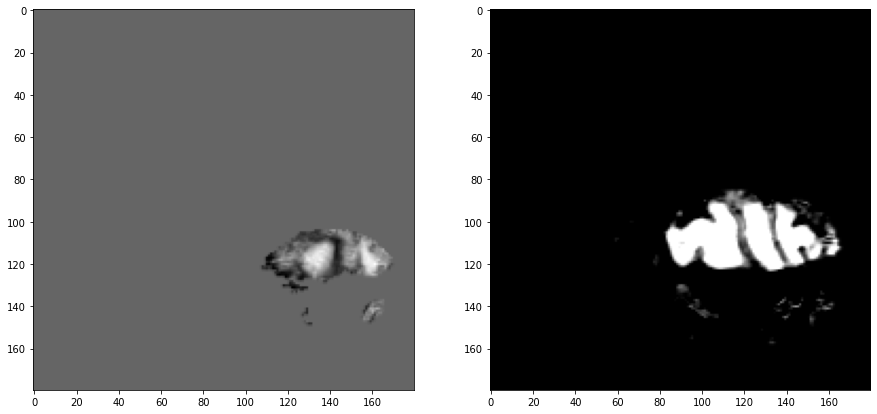

In [5]:
import numpy as np
import cv2
import random

from skimage.io import imread
from skimage import color
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import gaussian_blur, affine
import albumentations as A
import os
import nibabel as nib
from random import randint
from monai import transforms

class BratsTrainDataset(Dataset):
    def __init__(self, datapath='/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData', augmentation=None):
        self.augmentaion = augmentation
        self.datapath = datapath
        self.volumeType = ['flair', 't1ce', 't1', 't2', 'seg']
    def __getitem__(self, index):
        # 1st volume
        images = {}
        folderpaths = os.path.join(self.datapath, f'BraTS20_Training_{str(index+1).zfill(3)}')
        for name in self.volumeType:
            img = nib.load(os.path.join(folderpaths, f'BraTS20_Training_{str(index+1).zfill(3)}_{name}.nii')).get_fdata()
            if name == 'seg':
                img[img==4] = 3
            images[name] = img
        # normalize the non-zero voxels in images
        images['flair'] = self.normalize(images['flair'])
        images['t1ce'] = self.normalize(images['t1ce'])
        images['t1'] = self.normalize(images['t1'])
        images['t2'] = self.normalize(images['t2'])

        _, _, max_z = images['flair'].shape
        while True:
            slice_z_num = randint(0, max_z-1)
            if np.max(images['seg'][:, :, slice_z_num]) != 0: break

        image_slice1, seg_slice1 = self.get_slice(images)
        image_slice2, seg_slice2 = self.get_slice(images)
        whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.mask_label_process(seg_slice1)
        whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2 = self.mask_label_process(seg_slice2)
        if self.augmentaion is not None:
            image1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.data_transform(
                image_slice1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1
            )
            image2, whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2 = self.data_transform(
                image_slice2, whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2
            )
        label1 = np.concatenate((whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1), axis=0)
        label2 = np.concatenate((whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2), axis=0)
        return image1, image2, label1, label2

    def __len__(self):
        return len(os.listdir(self.datapath)) - 1
    
    def crop_center(self, img, cropx=180, cropy=180):
        y, x = img.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        return img[starty:starty+cropy, startx:startx+cropx]


    def normalize(self, input):
        normalizeIntensity = transforms.NormalizeIntensity(nonzero=True)
        input_norm = normalizeIntensity(input)
        return input_norm

    def get_slice(self, images):

        flair = np.expand_dims(self.crop_center(images['flair'][:, :, slice_z_num]),axis=0)
        t1ce = np.expand_dims(self.crop_center(images['t1ce'][:, :, slice_z_num]), axis=0)
        t1 = np.expand_dims(self.crop_center(images['t1'][:, :, slice_z_num]), axis=0)
        t2 = np.expand_dims(self.crop_center(images['t2'][:, :, slice_z_num]), axis=0)
        seg = self.crop_center(images['seg'][:, :, slice_z_num])
        image = np.concatenate((flair, t1ce, t1, t2), axis=0)
        # 2nd 
        return image.astype('float32'), seg.astype('uint8')

    def data_transform(self, image, whole_tumor_label, tumor_core_label, enhanced_tumor_label):
        transformed = self.augmentaion(image=image[0, :, :], t1=image[1, :, :], t1ce=image[2, :, :], t2=image[3, :, :], mask=whole_tumor_label, tumorCore=tumor_core_label, enhancingTumor=enhanced_tumor_label)
        flair = np.expand_dims(transformed["image"], axis=0)
        t1 = np.expand_dims(transformed['t1'], axis=0)
        t1ce = np.expand_dims(transformed['t1ce'], axis=0)
        t2 = np.expand_dims(transformed['t2'], axis=0)
        image = np.concatenate((flair, t1, t1ce, t2), axis=0)

        whole_tumor_label = transformed["mask"] # [w, h]
        tumor_core_label = transformed['tumorCore']
        enhanced_tumor_label = transformed['enhancingTumor']
        whole_tumor_label = np.expand_dims(whole_tumor_label, axis=0) #[1, w, h]
        tumor_core_label = np.expand_dims(tumor_core_label, axis=0)
        enhanced_tumor_label = np.expand_dims(enhanced_tumor_label, axis=0)
        return image, whole_tumor_label, tumor_core_label, enhanced_tumor_label

    def mask_label_process(self, mask):
        whole_tumor_label = mask.copy()
        whole_tumor_label[mask==1] = 1
        whole_tumor_label[mask==2] = 1
        whole_tumor_label[mask==3] = 1
        

        tumor_core_label = mask.copy()
        tumor_core_label[mask==1] = 1
        tumor_core_label[mask==2] = 0
        tumor_core_label[mask==3] = 1
        

        enhanced_tumor_label = mask.copy()
        enhanced_tumor_label[mask==1] = 0
        enhanced_tumor_label[mask==2] = 0
        enhanced_tumor_label[mask==3] = 1

        return whole_tumor_label, tumor_core_label, enhanced_tumor_label

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    train_transform = A.Compose([
        # A.Resize(200, 200),
        # A.CropNonEmptyMaskIfExists(height=150, width=150),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(1.0, 1.5), p=0.5),
        A.Affine(translate_percent=(0, 0.25), p=0.5),
        A.ColorJitter(brightness=0.6)],
        additional_targets={'t1': 'image', 't1ce': 'image', 't2': 'image', 'tumorCore': 'mask', 'enhancingTumor': 'mask'}
        )

    train_dataset = BratsTrainDataset(augmentation=train_transform)
    dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,drop_last=False)
    for batch_idx, data in enumerate(dataloader):
        image1, image2, label1, label2 = data
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
        ax[0].imshow(image1[0, 0, :, :], cmap='gray')
        ax[1].imshow(image2[0, 0, :, :], cmap='gray')
        # plt.imshow(image2[0, 0, :, :])
        break


/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_227
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_225
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_194
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_188
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_179
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_185
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_186
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_208
240 240
240 240
240 240
240 240
240 240
/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train

IndexError: too many indices for tensor of dimension 3

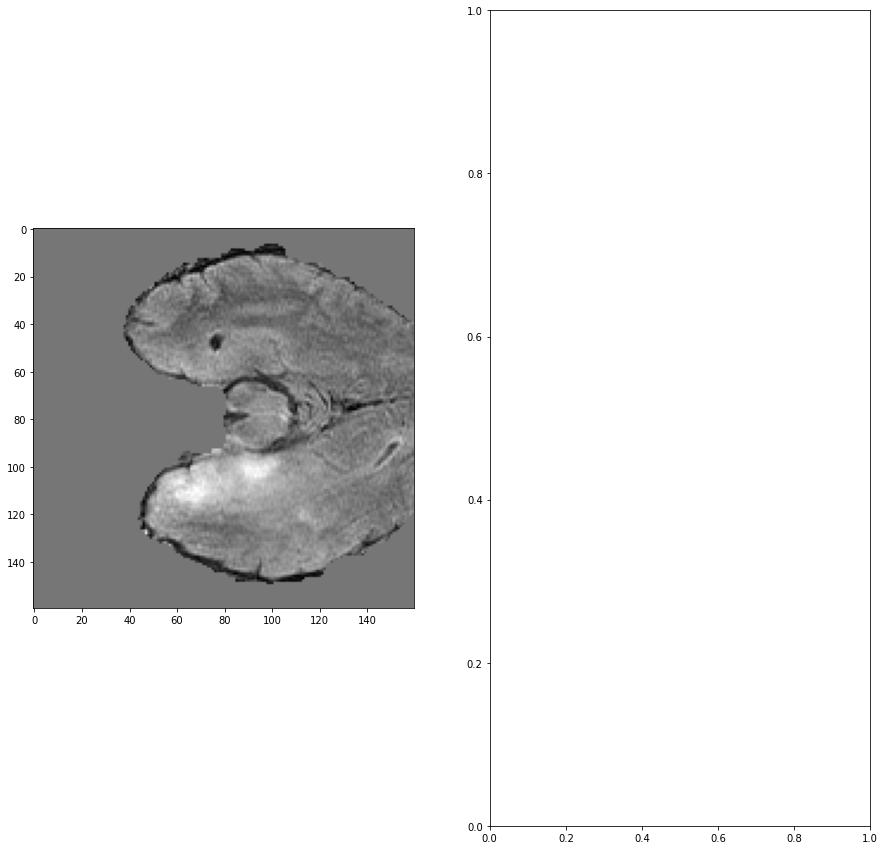

In [4]:
from glob import glob

class BratsSuperviseTrainDataset(Dataset):
    def __init__(self, datapaths, augmentation=None):
        self.augmentaion = augmentation
        self.datapath = datapaths
        self.volumeType = ['flair', 't1ce', 't1', 't2', 'seg']
    
    def __getitem__(self, index):
        images = {}
        # folderpaths = os.path.join(self.datapath, f'BraTS20_Training_{str(index).zfill(3)}')
        folderpath = self.datapath[index]
        print(folderpath)
        for name in self.volumeType:
            img = nib.load(os.path.join(folderpath, f'{folderpath[57:77]}_{name}.nii')).get_fdata()
            if name == 'seg':
                img[img==4] = 3
            images[name] = img
        # normalize the non-zero voxels in images
        images['flair'] = self.normalize(images['flair'])
        images['t1ce'] = self.normalize(images['t1ce'])
        images['t1'] = self.normalize(images['t1'])
        images['t2'] = self.normalize(images['t2'])

        image1, seg_slice1 = self.get_slice(images)
        whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.mask_label_process(seg_slice1)
        if self.augmentaion is not None:
            image1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.data_transform(
                image1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1
            )
        label1 = np.concatenate((whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1), axis=0)
        return image1, label1

    def __len__(self):
        return len(self.datapath) - 1
    
    def crop_center(self, img, cropx=160, cropy=160):
        y, x = img.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        return img[starty:starty+cropy, startx:startx+cropx]


    def normalize(self, input):
        normalizeIntensity = transforms.NormalizeIntensity(nonzero=True)
        input_norm = normalizeIntensity(input)
        return input_norm

    def get_slice(self, images):
        _, _, max_z = images['flair'].shape
        while True:
            slice_z_num = randint(0, max_z-1)
            if np.max(images['seg'][:, :, slice_z_num]) != 0: break

        flair = np.expand_dims(self.crop_center(images['flair'][:, :, slice_z_num]),axis=0)
        t1ce = np.expand_dims(self.crop_center(images['t1ce'][:, :, slice_z_num]), axis=0)
        t1 = np.expand_dims(self.crop_center(images['t1'][:, :, slice_z_num]), axis=0)
        t2 = np.expand_dims(self.crop_center(images['t2'][:, :, slice_z_num]), axis=0)
        seg = self.crop_center(images['seg'][:, :, slice_z_num])
        image = np.concatenate((flair, t1ce, t1, t2), axis=0)

        return image.astype('float32'), seg.astype('uint8')

    def data_transform(self, image, whole_tumor_label, tumor_core_label, enhanced_tumor_label):
        transformed = self.augmentaion(image=image[0, :, :], t1=image[1, :, :], t1ce=image[2, :, :], t2=image[3, :, :], mask=whole_tumor_label, tumorCore=tumor_core_label, enhancingTumor=enhanced_tumor_label)
        flair = np.expand_dims(transformed["image"], axis=0)
        t1 = np.expand_dims(transformed['t1'], axis=0)
        t1ce = np.expand_dims(transformed['t1ce'], axis=0)
        t2 = np.expand_dims(transformed['t2'], axis=0)
        image = np.concatenate((flair, t1, t1ce, t2), axis=0)

        whole_tumor_label = transformed["mask"] # [w, h]
        tumor_core_label = transformed['tumorCore']
        enhanced_tumor_label = transformed['enhancingTumor']
        whole_tumor_label = np.expand_dims(whole_tumor_label, axis=0) #[1, w, h]
        tumor_core_label = np.expand_dims(tumor_core_label, axis=0)
        enhanced_tumor_label = np.expand_dims(enhanced_tumor_label, axis=0)
        return image, whole_tumor_label, tumor_core_label, enhanced_tumor_label

    def mask_label_process(self, mask):
        whole_tumor_label = mask.copy()
        whole_tumor_label[mask==1] = 1
        whole_tumor_label[mask==2] = 1
        whole_tumor_label[mask==3] = 1
        

        tumor_core_label = mask.copy()
        tumor_core_label[mask==1] = 1
        tumor_core_label[mask==2] = 0
        tumor_core_label[mask==3] = 1
        

        enhanced_tumor_label = mask.copy()
        enhanced_tumor_label[mask==1] = 0
        enhanced_tumor_label[mask==2] = 0
        enhanced_tumor_label[mask==3] = 1

        return whole_tumor_label, tumor_core_label, enhanced_tumor_label

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    train_transform = A.Compose([
        # A.Resize(200, 200),
        # A.CropNonEmptyMaskIfExists(height=150, width=150),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(1.0, 1.5), p=0.5),
        A.Affine(translate_percent=(0, 0.25), p=0.5),
        A.ColorJitter(brightness=0.6)],
        additional_targets={'t1': 'image', 't1ce': 'image', 't2': 'image', 'tumorCore': 'mask', 'enhancingTumor': 'mask'}
        )
    train_paths = glob('/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/*')
    train_dataset = BratsSuperviseTrainDataset(train_paths, augmentation=None)
    dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,drop_last=False)
    for batch_idx, data in enumerate(dataloader):
        image1, label1 = data
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
        ax[0].imshow(image1[0, 0, :, :], cmap='gray')
        ax[1].imshow(label1[0, 0, :, :], cmap='gray')
        # plt.imshow(image2[0, 0, :, :])
        break


In [51]:
text = '/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Train/BraTS20_Training_193'
text[-20:]

'BraTS20_Training_193'

In [48]:
len(text)

77

torch.Size([1, 240, 240, 155]) torch.Size([1, 3, 240, 240, 155])


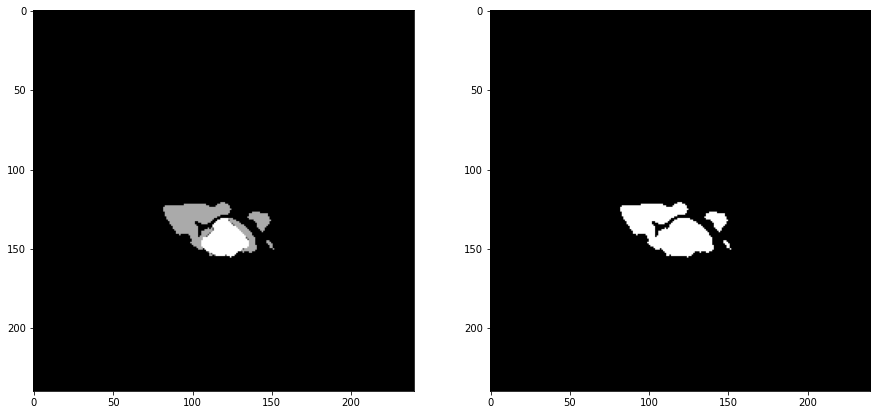

In [14]:
import numpy as np
import cv2
import random

from skimage.io import imread
from skimage import color
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import gaussian_blur, affine
import albumentations as A
import os
import nibabel as nib
from random import randint
from monai import transforms
from glob import glob

class BratsTestDataset(Dataset):
    def __init__(self, datapaths, augmentation=None):
        self.augmentaion = augmentation
        self.datapath = datapaths
        self.volumeType = ['flair', 't1ce', 't1', 't2', 'seg']
    
    def __getitem__(self, index):
        images = {}
        # folderpaths = os.path.join(self.datapath, f'BraTS20_Training_{str(index).zfill(3)}')
        folderpath = self.datapath[index]
        for name in self.volumeType:
            img = nib.load(os.path.join(folderpath, f'{folderpath[-20:]}_{name}.nii')).get_fdata()
            if name == 'seg':
                img[img==4] = 3
            images[name] = img
        # normalize the non-zero voxels in images
        images['flair'] = self.normalize(images['flair'])
        images['t1ce'] = self.normalize(images['t1ce'])
        images['t1'] = self.normalize(images['t1'])
        images['t2'] = self.normalize(images['t2'])

        whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.mask_label_process(images['seg'])
        
        label = np.concatenate((np.expand_dims(whole_tumor_label1, 0), np.expand_dims(tumor_core_label1, 0), np.expand_dims(enhanced_tumor_label1, 0)), axis=0)
        return images, label

    def __len__(self):
        return len(self.datapath) - 1
    
    def normalize(self, input):
        normalizeIntensity = transforms.NormalizeIntensity(nonzero=True)
        input_norm = normalizeIntensity(input)
        return input_norm


    def mask_label_process(self, mask):
        whole_tumor_label = mask.copy()
        whole_tumor_label[mask==1] = 1
        whole_tumor_label[mask==2] = 1
        whole_tumor_label[mask==3] = 1
        

        tumor_core_label = mask.copy()
        tumor_core_label[mask==1] = 1
        tumor_core_label[mask==2] = 0
        tumor_core_label[mask==3] = 1
        

        enhanced_tumor_label = mask.copy()
        enhanced_tumor_label[mask==1] = 0
        enhanced_tumor_label[mask==2] = 0
        enhanced_tumor_label[mask==3] = 1

        return whole_tumor_label, tumor_core_label, enhanced_tumor_label

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    train_transform = A.Compose([
        # A.Resize(200, 200),
        # A.CropNonEmptyMaskIfExists(height=150, width=150),
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(1.0, 1.5), p=0.5),
        A.Affine(translate_percent=(0, 0.25), p=0.5),
        A.ColorJitter(brightness=0.6)],
        additional_targets={'t1': 'image', 't1ce': 'image', 't2': 'image', 'tumorCore': 'mask', 'enhancingTumor': 'mask'}
        )
    test_paths = glob('/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/Test/*')
    test_dataset = BratsTestDataset(test_paths, augmentation=None)
    dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False,pin_memory=True,drop_last=False)
    for batch_idx, data in enumerate(dataloader):
        images, label = data
        print(images['flair'].shape, label.shape)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
        ax[0].imshow(images['seg'][0, :, :, 120], cmap='gray')
        ax[1].imshow(label[0, 0, :, :, 120], cmap='gray')
        # plt.imshow(image2[0, 0, :, :])
        break

In [ ]:
class BratsTrainDataset(Dataset):

    def __init__(self, image_path, mask_path, augmentation=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.augmentation = augmentation
        self.images_paths = self.get_volume_paths(image_path)
        self.masks_paths = self.get_volume_paths(mask_path)

    def __len__(self):
        return len(self.image_path) 

    def get_volume_paths(self, image_path):
        images = {}
        for index in range(158, 260):
            index = str(index).zfill(3)
            image_list = []
            for image_path in image_paths:
                if f'BraTS20_Training_{index}' in image_path:
                    image_list.append(image_path)
            images[f'BraTS20_Training_{index}'] = sorted(image_list)
            image_list = []
    def __getitem__(self, index):
        image_path = self.image_path[index]
        mask_path = self.mask_path[index]
        # unlabeled_image_path = self.unlabeled_image_path[index]
        volumen_index = image_path[-35:-15]
        index_in_volume = (self.images_paths[volumen_index]).index(image_path)
        while True:
            if index_in_volume - 0 < 5:
                left_bound = 0
            else:
                left_bound = index_in_volume - 5
            if index_in_volume + 5 > len(self.images_paths[volumen_index]):
                right_bound = len(self.images_paths[volumen_index])
            else:
                right_bound = index_in_volume + 5 
            index1 = randint(left_bound, right_bound)
            if index1 != index: break
        image_path1 = self.images_paths[index1]
        mask_path1 = self.masks_paths[index1]
        image = np.load(image_path).astype('float32')
        mask = np.load(mask_path).astype('uint8')
        image1 = np.load(image_path1).astype('float32')
        mask1 = np.load(mask_path1).astype('uint8')
        
        whole_tumor_label, tumor_core_label, enhanced_tumor_label = self.one_hot_label(mask)
        whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.one_hot_label(mask1)
        
        if self.augmentation is not None:
            image1, whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1 = self.data_transform(
                image, whole_tumor_label, tumor_core_label, enhanced_tumor_label
            )
            image2, whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2 = self.data_transform(
                image, whole_tumor_label, tumor_core_label, enhanced_tumor_label
            )

        label1 = np.concatenate((whole_tumor_label1, tumor_core_label1, enhanced_tumor_label1), axis=0)
        label2 = np.concatenate((whole_tumor_label2, tumor_core_label2, enhanced_tumor_label2), axis=0)
        return image1.astype('float32'), image2.astype('float32'), label1.astype('uint8'), label2.astype('uint8')

    def one_hot_label(self, mask):
        whole_tumor_label = mask.copy()
        whole_tumor_label[mask==1] = 1
        whole_tumor_label[mask==2] = 1
        whole_tumor_label[mask==3] = 1
        

        tumor_core_label = mask.copy()
        tumor_core_label[mask==1] = 1
        tumor_core_label[mask==2] = 0
        tumor_core_label[mask==3] = 1
        

        enhanced_tumor_label = mask.copy()
        enhanced_tumor_label[mask==1] = 0
        enhanced_tumor_label[mask==2] = 0
        enhanced_tumor_label[mask==3] = 1

        return whole_tumor_label, tumor_core_label, enhanced_tumor_label
    def data_transform(self, image, whole_tumor_label, tumor_core_label, enhanced_tumor_label):
        transformed = self.augmentation(image=image[0, :, :], t1=image[1, :, :], t1ce=image[2, :, :], t2=image[3, :, :], mask=whole_tumor_label, tumorCore=tumor_core_label, enhancingTumor=enhanced_tumor_label)
        flair = np.expand_dims(transformed["image"], axis=0)
        t1 = np.expand_dims(transformed['t1'], axis=0)
        t1ce = np.expand_dims(transformed['t1ce'], axis=0)
        t2 = np.expand_dims(transformed['t2'], axis=0)
        image = np.concatenate((flair, t1, t1ce, t2), axis=0)

        whole_tumor_label = transformed["mask"] # [w, h]
        tumor_core_label = transformed['tumorCore']
        enhanced_tumor_label = transformed['enhancingTumor']
        whole_tumor_label = np.expand_dims(whole_tumor_label, axis=0) #[1, w, h]
        tumor_core_label = np.expand_dims(tumor_core_label, axis=0)
        enhanced_tumor_label = np.expand_dims(enhanced_tumor_label, axis=0)
        return image, whole_tumor_label, tumor_core_label, enhanced_tumor_label

In [15]:
from glob import glob

index = str(178).zfill(3)
images = {}
image_paths = glob('/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_TCIA_HGG/image/*')
for index in range(158, 260):
    index = str(index).zfill(3)
    image_list = []
    for image_path in image_paths:
        if f'BraTS20_Training_{index}' in image_path:
            image_list.append(image_path)
    images[f'BraTS20_Training_{index}'] = sorted(image_list)
    image_list = []

In [24]:
'/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_TCIA_HGG/image/BraTS20_Training_259-slice065_z.npy' in images['BraTS20_Training_259']

True

In [25]:
text = '/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_TCIA_HGG/image/BraTS20_Training_259-slice065_z.npy'

In [36]:
text[-35:-15]

'BraTS20_Training_259'